In [1]:
import os
os.chdir("../../../../")

import itertools
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

#!pip install pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from scripts.python.tsmodel import * 

import warnings
warnings.filterwarnings('ignore')

In [2]:
filedir = os.getcwd() + "/data/tourism/palau/intermediate/"
filepath = filedir + [file for file in os.listdir(filedir) if ".csv" in file][0]

## Preprocessing
### Use `stringency_index` as a proxy

In [3]:
covid_data = pd.read_csv(os.getcwd() + "/data/tourism/owid-covid-data.csv")

# There is no Palau's stringency index, using Oceania's mean as the proxy
oceania_covid = (covid_data[covid_data.continent == "Oceania"]
                 .reset_index()
                 .drop("index", axis=1))
oceania_index = oceania_covid[["date", "location", "stringency_index"]]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])
oceania_index = oceania_index.groupby("date").mean().reset_index()
oceania_index.head(5)

,date,stringency_index
0,2020-01-26,5.560
1,2020-01-27,5.560
2,2020-01-28,5.560
3,2020-01-29,5.560
4,2020-01-30,8.335


In [4]:
oceania_index["year"], oceania_index["month"] = \
    oceania_index["date"].dt.year, oceania_index["date"].dt.month
oceania_index = oceania_index.groupby(["year", "month"]).mean().reset_index()
oceania_index["date"] = [str(year) + "-" + str(month)
                         for year, month in zip(oceania_index.year, oceania_index.month)]
oceania_index["date"] = pd.to_datetime(oceania_index["date"])

In [5]:
oceania_index.head(5)

,year,month,stringency_index,date
0,2020,1,6.485000,2020-01-01
1,2020,2,18.961379,2020-02-01
2,2020,3,41.960753,2020-03-01
3,2020,4,82.458000,2020-04-01
4,2020,5,64.930000,2020-05-01


### Read Palau's intermediate files

In [6]:
palau = pd.read_csv(filepath).drop("Unnamed: 0", axis=1)
palau["Date"] = pd.to_datetime(palau["Date"])
palau = (palau.merge(oceania_index, how="left", left_on="Date", right_on="date")
         .drop("date", axis=1)
         .fillna(0)
         .rename({"stringency_index": "covid"}, axis=1))
palau.head(5)

,Date,JAPAN,SOUTH KOREA,TAIWAN,CHINA,USA/CANADA,EUROPE,OTHERS,Total,year,month,covid
0,2007-06-01,856.0,1291.0,3245.0,86.0,669.0,99.0,463.0,6709.0,0.0,0.0,0.0
1,2007-07-01,2119.0,1366.0,3269.0,33.0,653.0,144.0,437.0,8021.0,0.0,0.0,0.0
2,2007-08-01,3476.0,1354.0,3046.0,46.0,580.0,256.0,438.0,9196.0,0.0,0.0,0.0
3,2007-09-01,3022.0,910.0,2497.0,61.0,559.0,145.0,401.0,7595.0,0.0,0.0,0.0
4,2007-10-01,1807.0,1082.0,2298.0,49.0,774.0,390.0,395.0,6795.0,0.0,0.0,0.0


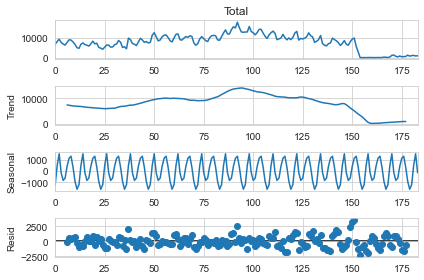

In [7]:
decompose = seasonal_decompose(palau["Total"], period=12, model="additive")
f = decompose.plot()
plt.rcParams.update({'figure.figsize': (10, 9)})

## SARIMAX

### Transformation 

[Scaled Logit Transformation](https://otexts.com/fpp3/limits.html#forecasts-constrained-to-an-interval):
$$y = \log\left(\frac{x-a}{b-x}\right)$$
and Inverse Transformation is: 
$$ x  = \frac{(b-a)e^y}{1+e^y} + a $$


In [8]:
# With additional +/-1 to prevent +/- inf during transformation
lower = palau["Total"].min() - 1
upper = palau["Total"].max() + 1

palau["scaled_total"] = scaled_logit_transform(palau["Total"])
print("Min: {}, Max: {}".format(
    palau["scaled_total"].min(), palau["scaled_total"].max()))

Min: -9.781941194456632, Max: 9.781941194456632


<AxesSubplot:>

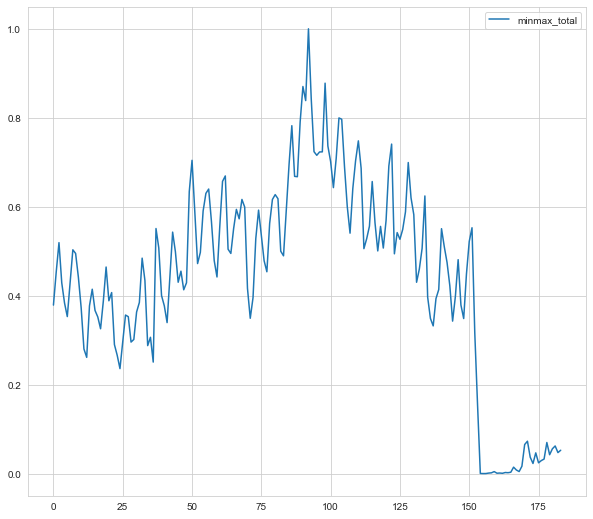

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
palau["minmax_total"] = scaler.fit(
    palau[["Total"]]).transform(palau[["Total"]])
palau[["minmax_total"]].plot()

### Train-Test Split

In [10]:
# Use 90% of the data as the training data
size = len(palau)
train_size = int(0.9*size)
train, test = model_selection.train_test_split(
    palau[["Date", "Total", "covid", "scaled_total", "minmax_total"]], train_size=train_size)

### Stepwise searching

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=511.921, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=465.793, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=509.922, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=491.756, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=456.169, Time=0.52 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=486.122, Time=0.52 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=454.439, Time=0.64 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=463.421, Time=0.11 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=455.750, Time=

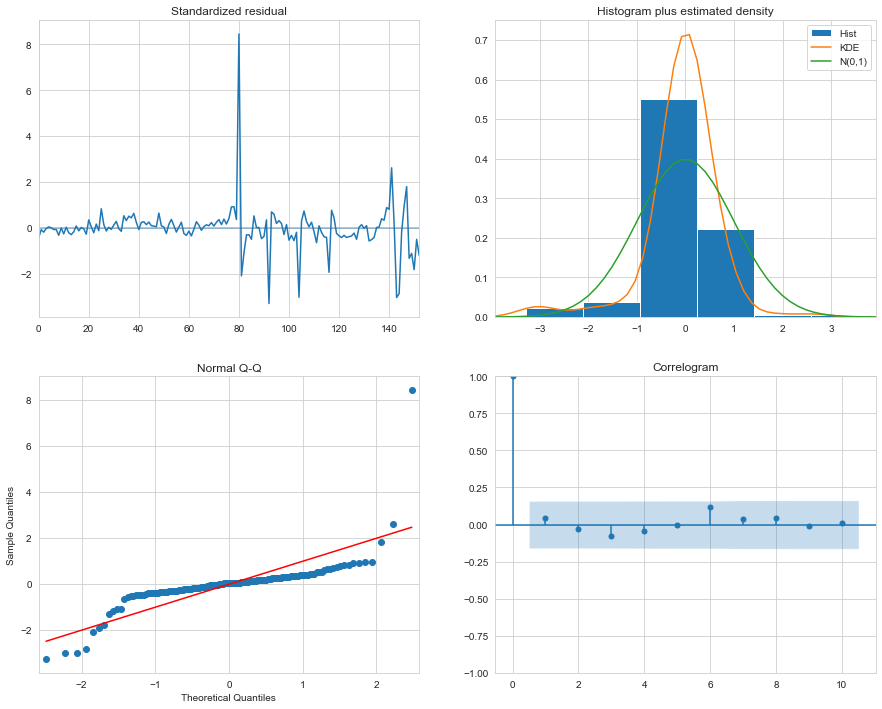

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-197.903, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-358.608, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-284.910, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-199.903, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-331.874, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-377.565, Time=1.28 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-380.016, Time=1.50 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=-381.605, Time=1.43 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(2,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=-285.9

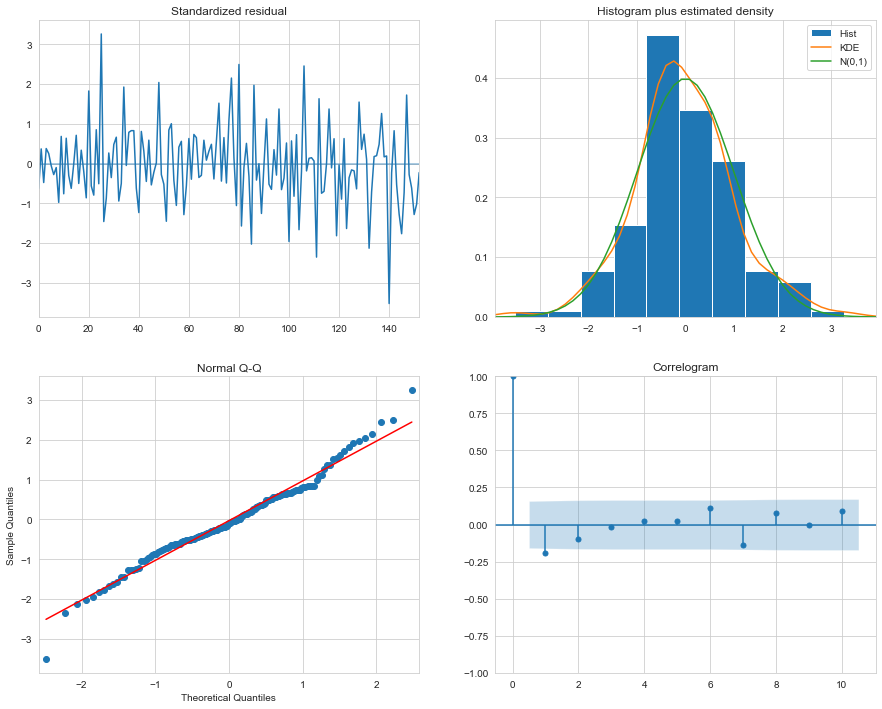

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=2625.291, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2795.353, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2645.531, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2709.091, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2793.390, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=2673.142, Time=0.11 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=2626.998, Time=0.45 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=2627.431, Time=1.47 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=2643.887, Time=0.40 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=2623.317, Time=0.47 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=2675.046, Time=0.16 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=2625.063, Time=0.56 sec
 ARIMA(2,0,1)(0,1,2)[12] inte

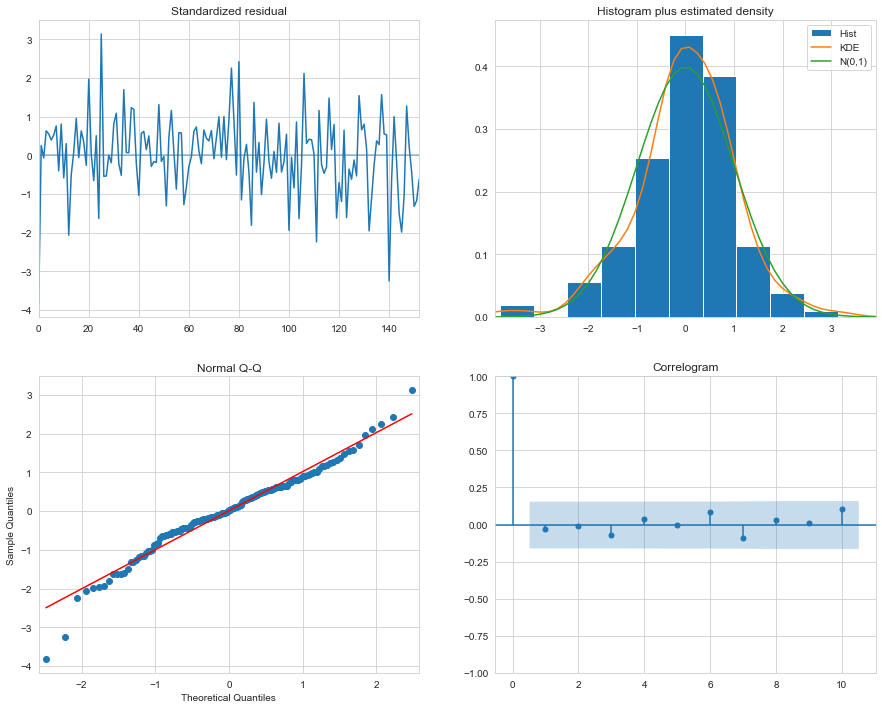

In [11]:
models = {"dv": [], "params": []}
for var in ["scaled_total", "minmax_total", "Total"]:
    models["dv"].append(var)
    stepwise_fit = auto_arima(train[var], X=train[["covid"]],
                              start_p=1, start_q=1,
                              max_p=5, max_q=5, m=12,
                              start_P=0, seasonal=True,
                              d=0, D=1, trace=True,
                              error_action='ignore',  # don't want to know if an order does not work
                              suppress_warnings=True,  # don't want convergence warnings
                              stepwise=True)  # set to stepwise
    print(stepwise_fit.summary())
    
    models["params"].append(stepwise_fit.get_params())
    stepwise_fit.plot_diagnostics(figsize=(15, 12))
    plt.show()

### Manually Searching

In [12]:
## Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

## list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

## Search the minimim aic
ms = {"dv": [], "models": []}
for dv in ["scaled_total", "minmax_total", "Total"]:
    ms["dv"].append(dv)
    all_res = sarimax(train[dv], train["covid"], all_param)
    all_res.sort(key=lambda x: x[1])
    ms["models"].append(all_res)
    print(f"{dv}'s searching has finished.")

Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:503.87
Tried out SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:493.07
Tried out SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:492.1
Tried out SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:509.92
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:479.11
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:479.44
Tried out SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:489.77
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:489.93
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:491.9
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:490.48
Tried out SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:477.73
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:478.61
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:490.18
Tried out SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:491.91
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:491.02
Tried out SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:484.39
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:478.36
Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:479.28
Tried out SARIMAX(0, 0, 1)x(0,

Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:461.18
Tried out SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:433.57
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:434.49
Tried out SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:450.93
Tried out SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:449.5
Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:450.54
Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:451.0
Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:435.54
Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:436.44
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:479.55
Tried out SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:477.76
Tried out SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:478.28
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:508.99
Tried out SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:448.92
Tried out SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:450.83
Tried out SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:476.82
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:468.85
Tried out SARIMAX(1, 1, 0)x(1, 0, 2, 12) - AIC:470.82
Tried out SARIMAX(1, 1, 0)x(1,

Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:451.64
Tried out SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:453.76
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:491.19
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:433.82
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:435.8
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:452.16
Tried out SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:448.71
Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:451.18
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:464.47
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:435.81
Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:437.02
Tried out SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:453.04
Tried out SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:450.71
Tried out SARIMAX(2, 1, 2)x(2, 0, 2, 12) - AIC:452.24
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:454.32
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:437.79
Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC:439.69
scaled_total's searching has finished.
Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - A

Tried out SARIMAX(1, 0, 1)x(1, 0, 1, 12) - AIC:-422.08
Tried out SARIMAX(1, 0, 1)x(1, 0, 2, 12) - AIC:-420.02
Tried out SARIMAX(1, 0, 1)x(1, 1, 0, 12) - AIC:-366.94
Tried out SARIMAX(1, 0, 1)x(1, 1, 1, 12) - AIC:-393.32
Tried out SARIMAX(1, 0, 1)x(1, 1, 2, 12) - AIC:-395.57
Tried out SARIMAX(1, 0, 1)x(2, 0, 0, 12) - AIC:-407.02
Tried out SARIMAX(1, 0, 1)x(2, 0, 1, 12) - AIC:-418.97
Tried out SARIMAX(1, 0, 1)x(2, 0, 2, 12) - AIC:-417.0
Tried out SARIMAX(1, 0, 1)x(2, 1, 0, 12) - AIC:-383.18
Tried out SARIMAX(1, 0, 1)x(2, 1, 1, 12) - AIC:-388.71
Tried out SARIMAX(1, 0, 1)x(2, 1, 2, 12) - AIC:-392.81
Tried out SARIMAX(1, 0, 2)x(0, 0, 0, 12) - AIC:-362.72
Tried out SARIMAX(1, 0, 2)x(0, 0, 1, 12) - AIC:-333.25
Tried out SARIMAX(1, 0, 2)x(0, 0, 2, 12) - AIC:-391.2
Tried out SARIMAX(1, 0, 2)x(0, 1, 0, 12) - AIC:-338.68
Tried out SARIMAX(1, 0, 2)x(0, 1, 1, 12) - AIC:-394.19
Tried out SARIMAX(1, 0, 2)x(0, 1, 2, 12) - AIC:-391.84
Tried out SARIMAX(1, 0, 2)x(1, 0, 0, 12) - AIC:-401.85
Tried out SA

Tried out SARIMAX(2, 1, 0)x(2, 0, 1, 12) - AIC:-420.92
Tried out SARIMAX(2, 1, 0)x(2, 0, 2, 12) - AIC:-423.13
Tried out SARIMAX(2, 1, 0)x(2, 1, 0, 12) - AIC:-382.85
Tried out SARIMAX(2, 1, 0)x(2, 1, 1, 12) - AIC:-388.5
Tried out SARIMAX(2, 1, 0)x(2, 1, 2, 12) - AIC:-389.47
Tried out SARIMAX(2, 1, 1)x(0, 0, 0, 12) - AIC:-355.29
Tried out SARIMAX(2, 1, 1)x(0, 0, 1, 12) - AIC:-377.18
Tried out SARIMAX(2, 1, 1)x(0, 0, 2, 12) - AIC:-382.55
Tried out SARIMAX(2, 1, 1)x(0, 1, 0, 12) - AIC:-333.39
Tried out SARIMAX(2, 1, 1)x(0, 1, 1, 12) - AIC:-391.18
Tried out SARIMAX(2, 1, 1)x(0, 1, 2, 12) - AIC:-389.8
Tried out SARIMAX(2, 1, 1)x(1, 0, 0, 12) - AIC:-395.49
Tried out SARIMAX(2, 1, 1)x(1, 0, 1, 12) - AIC:-416.33
Tried out SARIMAX(2, 1, 1)x(1, 0, 2, 12) - AIC:-414.26
Tried out SARIMAX(2, 1, 1)x(1, 1, 0, 12) - AIC:-361.95
Tried out SARIMAX(2, 1, 1)x(1, 1, 1, 12) - AIC:-389.71
Tried out SARIMAX(2, 1, 1)x(1, 1, 2, 12) - AIC:-391.68
Tried out SARIMAX(2, 1, 1)x(2, 0, 0, 12) - AIC:-405.53
Tried out SA

Tried out SARIMAX(1, 0, 0)x(0, 0, 2, 12) - AIC:2856.32
Tried out SARIMAX(1, 0, 0)x(0, 1, 0, 12) - AIC:2671.64
Tried out SARIMAX(1, 0, 0)x(0, 1, 1, 12) - AIC:2621.21
Tried out SARIMAX(1, 0, 0)x(0, 1, 2, 12) - AIC:2623.1
Tried out SARIMAX(1, 0, 0)x(1, 0, 0, 12) - AIC:2839.16
Tried out SARIMAX(1, 0, 0)x(1, 0, 1, 12) - AIC:2810.93
Tried out SARIMAX(1, 0, 0)x(1, 0, 2, 12) - AIC:2813.34
Tried out SARIMAX(1, 0, 0)x(1, 1, 0, 12) - AIC:2643.62
Tried out SARIMAX(1, 0, 0)x(1, 1, 1, 12) - AIC:2623.11
Tried out SARIMAX(1, 0, 0)x(1, 1, 2, 12) - AIC:2628.13
Tried out SARIMAX(1, 0, 0)x(2, 0, 0, 12) - AIC:2829.99
Tried out SARIMAX(1, 0, 0)x(2, 0, 1, 12) - AIC:2829.03
Tried out SARIMAX(1, 0, 0)x(2, 0, 2, 12) - AIC:2834.66
Tried out SARIMAX(1, 0, 0)x(2, 1, 0, 12) - AIC:2628.53
Tried out SARIMAX(1, 0, 0)x(2, 1, 1, 12) - AIC:2628.19
Tried out SARIMAX(1, 0, 0)x(2, 1, 2, 12) - AIC:2631.36
Tried out SARIMAX(1, 0, 1)x(0, 0, 0, 12) - AIC:2887.69
Tried out SARIMAX(1, 0, 1)x(0, 0, 1, 12) - AIC:2858.2
Tried out SA

Tried out SARIMAX(2, 0, 2)x(1, 0, 2, 12) - AIC:2826.98
Tried out SARIMAX(2, 0, 2)x(1, 1, 0, 12) - AIC:2646.66
Tried out SARIMAX(2, 0, 2)x(1, 1, 1, 12) - AIC:2627.94
Tried out SARIMAX(2, 0, 2)x(1, 1, 2, 12) - AIC:2628.39
Tried out SARIMAX(2, 0, 2)x(2, 0, 0, 12) - AIC:2830.35
LU decomposition error.
Tried out SARIMAX(2, 0, 2)x(2, 0, 2, 12) - AIC:2828.95
Tried out SARIMAX(2, 0, 2)x(2, 1, 0, 12) - AIC:2632.36
Tried out SARIMAX(2, 0, 2)x(2, 1, 1, 12) - AIC:2631.4
Tried out SARIMAX(2, 0, 2)x(2, 1, 2, 12) - AIC:2630.26
Tried out SARIMAX(2, 1, 0)x(0, 0, 0, 12) - AIC:2855.38
Tried out SARIMAX(2, 1, 0)x(0, 0, 1, 12) - AIC:2832.01
Tried out SARIMAX(2, 1, 0)x(0, 0, 2, 12) - AIC:2827.38
Tried out SARIMAX(2, 1, 0)x(0, 1, 0, 12) - AIC:2640.13
Tried out SARIMAX(2, 1, 0)x(0, 1, 1, 12) - AIC:2579.01
Tried out SARIMAX(2, 1, 0)x(0, 1, 2, 12) - AIC:2580.23
Tried out SARIMAX(2, 1, 0)x(1, 0, 0, 12) - AIC:2816.9
Tried out SARIMAX(2, 1, 0)x(1, 0, 1, 12) - AIC:2790.86
Tried out SARIMAX(2, 1, 0)x(1, 0, 2, 12) - 

### Cross-validation

In [13]:
for i in range(len(ms["models"])):
    print(ms["models"][i][:5])

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x287884af0>, 430.80904692961474, ((1, 1, 1), (0, 1, 1, 12))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x2b5ba7940>, 431.0547272687773, ((0, 1, 2), (0, 1, 1, 12))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x3145dfc10>, 431.31847569797935, ((2, 0, 1), (0, 1, 1, 12))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x312301730>, 431.5867267273098, ((1, 0, 2), (0, 1, 1, 12))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x287fd5970>, 431.59000493786436, ((0, 1, 1), (0, 1, 1, 12)))]
[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x3bdf2d4c0>, -426.8340246915939, ((0, 1, 2), (2, 0, 2, 12))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x3bdf6a460>, -425.8169270156523, ((0, 1, 2), (1, 0, 1, 12))), (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x49a35

In [14]:
scaled_models = []
for idx in range(len(ms["models"][0][:5])):
    order, seasonal_order = ms["models"][0][:5][idx][-1]
    model = pm.ARIMA(order, seasonal_order, exog=train["covid"])
    scaled_models.append(model)
print(scaled_models)
compare_models(data=train["scaled_total"], models=scaled_models)

[ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)), ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)), ARIMA(order=(2, 0, 1), seasonal_order=(0, 1, 1, 12)), ARIMA(order=(1, 0, 2), seasonal_order=(0, 1, 1, 12)), ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))]
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 ......

[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................


{'model': [ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(2, 0, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 0, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))],
 'cv_scores': [array([ 59.46083747,  48.5008139 ,  54.62415759, 103.28969877,
         118.10870816, 161.92650478, 126.07084679, 101.90918207,
          88.43730345, 106.07581107, 171.83034237, 191.08560152,
         131.56954299,  51.33194005,  79.52073519,  62.59240922,
          91.4509115 , 119.5724935 , 124.39721314, 137.34031623,
          65.97272267,  95.6669215 , 134.11707214, 187.92224809]),
  array([ 59.46083747,  48.5008139 ,  54.62415759, 103.28969877,
         118.10870816, 161.92650478, 126.07084679, 101.90918207,
          88.43730345, 106.07581107, 171.83034237, 191.08560152,
         131.56954299,  51.33194005,  79.52073519,  62.59240922,
          91.4509115 , 119.5724935 , 124.3972

### Best Logit Scaled Model

In [23]:
best_scaled = ms["models"][0][0][0]
best_scaled.save(filedir+"best_scaled.pkl")
scaled_mod = get_prediction_df(best_scaled, steps=19, exog=test["covid"])

lower = palau["Total"].min() - 1
upper = palau["Total"].max() + 1

for col_idx, col in enumerate(scaled_mod.columns):
    for row_idx, _ in enumerate(scaled_mod[col]):
        scaled_mod.iloc[row_idx, col_idx] = inverse_scaled_logit(
            scaled_mod.iloc[row_idx, col_idx], upper, lower)

In [24]:
scaled_mod = pd.concat([palau[["Date", "Total"]], scaled_mod], axis=1)
scaled_mod.head(20)

,Date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2007-06-01,6709.0,8856.000000,NaN,0.000000,NaN,NaN
1,2007-07-01,8021.0,6709.000821,NaN,0.000000,NaN,NaN
2,2007-08-01,9196.0,8020.999098,NaN,0.000000,NaN,NaN
3,2007-09-01,7595.0,9195.998889,NaN,0.000000,NaN,NaN
4,2007-10-01,6795.0,7595.001047,NaN,0.000000,NaN,NaN
5,2007-11-01,6252.0,6795.000819,NaN,0.000000,NaN,NaN
6,2007-12-01,7595.0,6252.000576,NaN,0.000000,NaN,NaN
7,2008-01-01,8911.0,7594.999015,NaN,0.000000,NaN,NaN
8,2008-02-01,8766.0,8910.998750,NaN,0.000000,NaN,NaN
9,2008-03-01,7817.0,8765.999864,NaN,0.000000,NaN,NaN


In [17]:
# MSE_mod2 = np.square(np.subtract(palau_stats["Total"], palau_stats["mean"])).mean()
# RMSE_mod2 = np.sqrt(MSE_mod2)
# RMSE_mod2

Text(0.5, 1.0, "Palau's Visitor Arrivals")

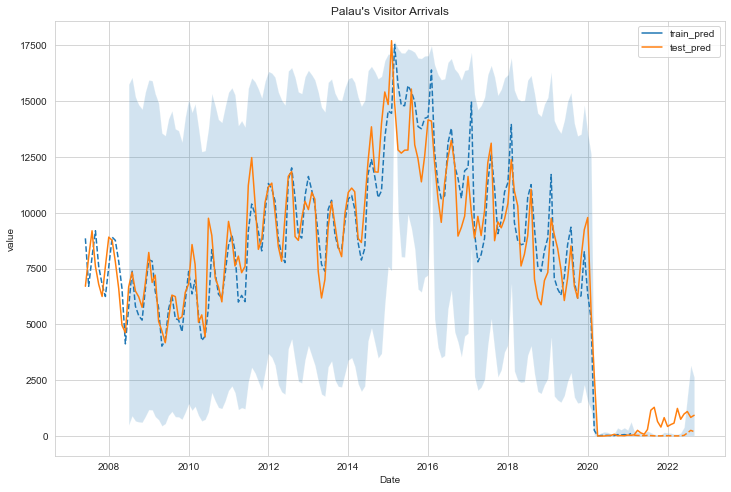

In [26]:
sclaed_viz_df = scaled_mod[["Date", "train_pred", "test_pred"]].melt(id_vars=["Date"])
sclaed_viz_df["Date"] = pd.to_datetime(sclaed_viz_df["Date"])

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(x="Date", y1="mean_ci_lower", y2="mean_ci_upper", data=scaled_mod, alpha=0.2)
sns.lineplot(data=sclaed_viz_df, x="Date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=scaled_mod, x="Date", y="Total")
plt.title("Palau's Visitor Arrivals")

### Best No-Transformation Models (existence of negative values)

In [27]:
original_models = []
for idx in range(len(ms["models"][-1][:5])):
    order, seasonal_order = ms["models"][-1][:5][idx][-1]
    model = pm.ARIMA(order, seasonal_order, exog=train["covid"])
    original_models.append(model)
print(original_models)
compare_models(data=train["Total"], models=original_models)

[ARIMA(order=(0, 0, 1), seasonal_order=(2, 0, 0, 12)), ARIMA(order=(0, 1, 1), seasonal_order=(1, 1, 2, 12)), ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)), ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)), ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))]
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 ......

{'model': [ARIMA(order=(0, 0, 1), seasonal_order=(2, 0, 0, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(1, 1, 2, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)),
  ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))],
 'cv_scores': [array([ 15.762777  ,  25.39840127,  13.85003619,  17.00489683,
          27.41376217,  25.48874918,  25.52901966,  13.96173782,
          11.77792516,  20.61861088,  12.25629438,  25.44642333,
          36.28080241,  21.03374615,  10.49950246,  22.49515506,
          19.90205421,  20.04577525,  16.60498261,  20.13338706,
          26.13557885,  19.75335944,  56.16025878, 147.27393304]),
  array([ 35.49179795,  38.84791079,  37.32626431,  20.95678051,
          23.22776158,  10.55611214,  26.37808059,  32.77661478,
          36.11462914,  47.39987106,  17.59770811,  12.49576708,
          10.75281395,  37.59799777,  50.10112223,  40.26554052,
          39.97080604,  36.93607326,  29.1227

In [28]:
best_original = ms["models"][-1][1][0]
best_original.save(filedir+"best_original.pkl")
original_mod = get_prediction_df(best_original, steps=(size-train_size), exog=test["covid"])
original_mod.columns.name = None
original_mod = pd.concat([palau[["Date", "Total"]], original_mod], axis=1)
original_mod.head(5)

,Date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2007-06-01,6709.0,0.000000,2032.414825,-3983.459859,3983.459859,NaN
1,2007-07-01,8021.0,5628.757246,1738.855745,2220.662613,9036.851880,NaN
2,2007-08-01,9196.0,7494.781131,1727.544007,4108.857094,10880.705167,NaN
3,2007-09-01,7595.0,8816.868184,1726.987578,5432.034730,12201.701639,NaN
4,2007-10-01,6795.0,7867.479734,1726.959920,4482.700489,11252.258980,NaN


Text(0.5, 1.0, "Palau's Visitor Arrivals")

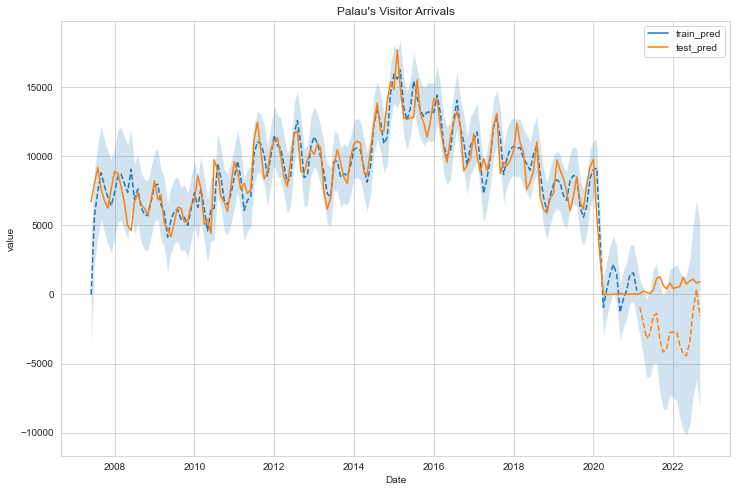

In [29]:
original_viz_df = original_mod[["Date", "train_pred", "test_pred"]].melt(id_vars=["Date"])

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(x="Date", y1="mean_ci_lower", y2="mean_ci_upper", data=original_mod, alpha=0.2)
sns.lineplot(data=original_viz_df, x="Date", y="value", hue="variable", linestyle="--")
sns.lineplot(data=original_mod, x="Date", y="Total")
plt.title("Palau's Visitor Arrivals")

### MinMax Transformation

In [30]:
minmax_models = []
for idx in range(len(ms["models"][1][:5])):
    order, seasonal_order = ms["models"][1][:5][idx][-1]
    model = pm.ARIMA(order, seasonal_order, exog=train["covid"])
    minmax_models.append(model)
print(minmax_models)
compare_models(data=train["minmax_total"], models=minmax_models)

[ARIMA(order=(0, 1, 2), seasonal_order=(2, 0, 2, 12)), ARIMA(order=(0, 1, 2), seasonal_order=(1, 0, 1, 12)), ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)), ARIMA(order=(1, 1, 1), seasonal_order=(2, 0, 2, 12)), ARIMA(order=(1, 1, 2), seasonal_order=(2, 0, 2, 12))]
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 ......

[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................


{'model': [ARIMA(order=(0, 1, 2), seasonal_order=(2, 0, 2, 12)),
  ARIMA(order=(0, 1, 2), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)),
  ARIMA(order=(1, 1, 1), seasonal_order=(2, 0, 2, 12)),
  ARIMA(order=(1, 1, 2), seasonal_order=(2, 0, 2, 12))],
 'cv_scores': [array([185.5172083 ,   9.6710497 ,  15.24725703,  54.82059527,
          14.84758947,  28.6837535 ,  25.77398961,  22.83559422,
          44.58014156,  21.45014862,  50.85955309,  45.84541016,
           9.59027833,  17.9828638 ,  25.28803483,  18.70128317,
          14.43792277,  18.73476452,  34.40285865,  20.50320706,
           9.9912389 ,  65.45552925,  54.1233627 , 151.16909696]),
  array([185.62380136,   9.3029297 ,  15.84851367,  53.71786952,
          14.82907653,  29.12084103,  25.73901107,  22.47260693,
          47.27803708,  21.20042066,  51.08241714,  45.95060178,
           9.85049464,  17.19683462,  25.1668215 ,  19.58535299,
          14.45407782,  28.28884544,  34.0863

In [34]:
best_minmax= ms["models"][1][5][0]
best_minmax.save(filedir+"bets_minmax.pkl")
minmax_mod = get_prediction_df(best_minmax, steps=19, exog=test["covid"])
minmax_mod.columns.name = None
minmax_mod.head(5)

,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,0.000000,1000.000003,-1959.963991,1959.963991,NaN
1,0.378769,0.081027,0.219959,0.537579,NaN
2,0.438347,0.079459,0.282611,0.594084,NaN
3,0.488009,0.077704,0.335712,0.640306,NaN
4,0.430206,0.077414,0.278478,0.581934,NaN


In [35]:
inv_minmax_mod = pd.DataFrame(scaler.inverse_transform(minmax_mod.iloc[1:]))
inv_minmax_mod.columns = minmax_mod.columns
firstrow = pd.DataFrame(minmax_mod.iloc[0]).T
inv_minmax_mod = (pd.concat([firstrow, inv_minmax_mod], axis=0)
                    .reset_index()
                    .drop("index",axis=1))
inv_minmax_mod = pd.concat([palau[["Date", "Total"]], inv_minmax_mod], axis=1)
inv_minmax_mod.head(5)

,Date,Total,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2007-06-01,6709.0,0.000000,1000.000003,-1959.963991,1959.963991,NaN
1,2007-07-01,8021.0,6708.999991,1435.990064,3896.471148,9521.528835,NaN
2,2007-08-01,9196.0,7764.131606,1408.218820,5006.033401,10522.229811,NaN
3,2007-09-01,7595.0,8643.646170,1377.137352,5946.466523,11340.825817,NaN
4,2007-10-01,6795.0,7619.943397,1371.995491,4932.841611,10307.045182,NaN


Text(0.5, 1.0, "Palau's Visitor Arrivals")

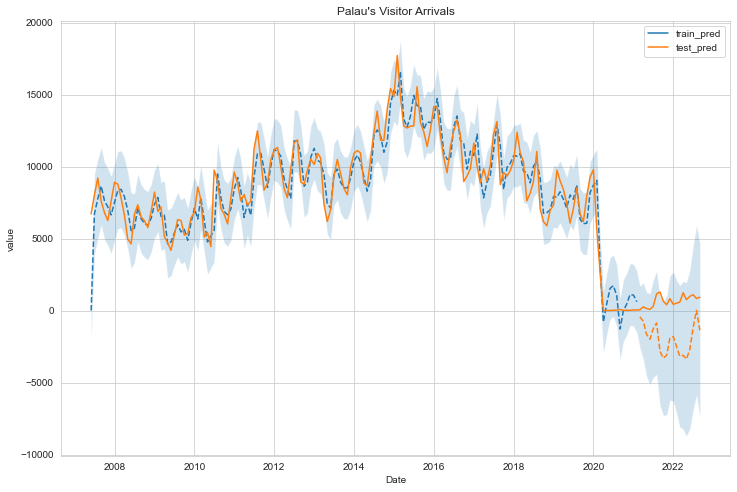

In [36]:
minmax_viz_df = inv_minmax_mod[["Date", "train_pred", "test_pred"]].melt(id_vars="Date")

fig, ax = plt.subplots(figsize=(12, 8))
ax.fill_between(x="Date", y1="mean_ci_lower",
                y2="mean_ci_upper", data=inv_minmax_mod, alpha=0.2)
sns.lineplot(data=minmax_viz_df, x="Date",
             y="value", hue="variable", linestyle="--")
sns.lineplot(data=inv_minmax_mod, x="Date", y="Total")
plt.title("Palau's Visitor Arrivals")